In [1]:
import sqlite3
import numpy as np

In [21]:
import os

dim = 128
dir = 'itwac'

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sql_path = f'{parent_dir}/{dir}/itwac{dim}.sqlite'
txt_path = f'{parent_dir}/{dir}/itwac{dim}.txt'

In [22]:
con = sqlite3.connect(sql_path)

In [148]:
cur = con.cursor()

In [149]:
with open(txt_path, 'w+') as out_file:
    for embedding in cur.execute("SELECT * FROM store"):
        str_embedding = [str(el) for el in embedding[:-1]]
        out_file.write('\t'.join(str_embedding)+'\n')

out_file.close()

In [150]:
embeddings_dim = 128
embeddings_path = f'itwac/itwac{embeddings_dim}.txt'

In [151]:
def load_word_embeddings(src_path):
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [152]:
embeddings = load_word_embeddings(embeddings_path)


In [154]:
embeddings['veder-']

array([-0.16270669,  0.19565818,  0.02219515,  0.03182968,  0.06380708,
       -0.01253813,  0.03079295, -0.02601201, -0.01590329,  0.13031897,
        0.05081404, -0.09052757,  0.09895489, -0.00091873, -0.07020305,
       -0.0220238 ,  0.12410183,  0.11773505,  0.14741947, -0.14965008,
        0.00541563,  0.18609737, -0.07359025, -0.07256421,  0.04886822,
       -0.03960319,  0.02102794, -0.03483714, -0.10940406,  0.07425313,
       -0.08097353, -0.02414978,  0.04955766, -0.04534756, -0.02043084,
        0.18009825,  0.19754723, -0.03405125, -0.00367098,  0.05356506,
       -0.0309161 ,  0.08483381,  0.01752819, -0.01335294,  0.06633461,
        0.09349912,  0.01673704, -0.0625938 ,  0.08394236,  0.09841841,
        0.02892375,  0.13715596,  0.03394483, -0.18145959,  0.17724273,
       -0.05658317,  0.01744641,  0.09634059, -0.03066679,  0.1391481 ,
       -0.0314896 ,  0.00351192,  0.14712372,  0.11076981, -0.12062329,
        0.04014482,  0.18628895,  0.03587203,  0.07064996,  0.01

In [155]:
min_value = 99999
max_value = -99999
for word in embeddings:
    for comp in embeddings[word]:
        if comp > max_value:
            max_value = comp
        elif comp < min_value:
            min_value = comp

print(f'Valore minimo = {min_value}')
print(f'Valore massimo = {max_value}')

Valore minimo = -0.45757773518562317
Valore massimo = 0.4659615755081177


In [156]:
words = ['mela', 'pera', 'banana', 'arancia', 'kiwi', 'mandarino', 'automobile', 'camion', 'pullman', 'moto', 'bici', 'autobus']

embs = [embeddings[word] for word in words] 
embs = np.stack(embs, axis=0) # la funzione stack "attacca" una lista di vettori, creando una matrice

In [157]:
embs.shape


(12, 128)

In [158]:
from sklearn.manifold import TSNE
reduced_embs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embs)

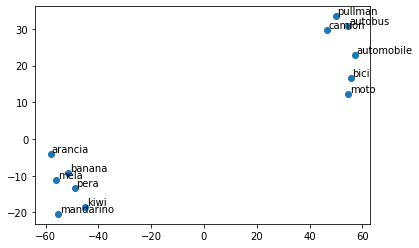

In [159]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(reduced_embs[:,0], reduced_embs[:,1])
for i, word in enumerate(words):
    ax.annotate(word, (reduced_embs[i,0]+0.5, reduced_embs[i, 1]+0.5))

In [160]:
conllu_dir = 'profiling_output/11152'

In [161]:
import os
all_documents_paths = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    all_documents_paths.append(file_path)


In [162]:
import re

def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub('\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

In [163]:
def get_tokens_from_file(src_path):
    document_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                # print('Ho trovato un - ')
                skip_ids = splitted_line[0].split('-')
                # print('Indici da saltare', skip_ids)
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = {
                    'word': word,
                    'pos': '_'
                }
                # print(f'Preso token {word}')
                document_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    # print(f'Preso token {word}')
                    document_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    document_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return document_tokens

In [164]:
all_documents = []

for document_path in all_documents_paths:
    document_tokens = get_tokens_from_file(document_path)
    all_documents.append(document_tokens)

In [165]:
all_documents[0][:20]


[{'word': '"', 'pos': 'PUNCT'},
 {'word': 'Gay', 'pos': 'PROPN'},
 {'word': 'Pride', 'pos': 'PROPN'},
 {'word': '?', 'pos': 'PUNCT'},
 {'word': 'Solo', 'pos': 'ADV'},
 {'word': 'folklore', 'pos': 'NOUN'},
 {'word': '"', 'pos': 'PUNCT'},
 {'word': '.', 'pos': 'PUNCT'},
 {'word': 'A', 'pos': 'ADP'},
 {'word': 'Novara', 'pos': 'PROPN'},
 {'word': 'il', 'pos': 'DET'},
 {'word': 'sindaco', 'pos': 'NOUN'},
 {'word': 'leghista', 'pos': 'ADJ'},
 {'word': 'nega', 'pos': 'VERB'},
 {'word': 'il', 'pos': 'DET'},
 {'word': 'patrocinio', 'pos': 'NOUN'},
 {'word': 'ed', 'pos': 'CCONJ'},
 {'word': 'è', 'pos': 'AUX'},
 {'word': 'polemica', 'pos': 'NOUN'},
 {'word': '"', 'pos': 'PUNCT'}]

In [166]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

In [167]:
def compute_filtered_embeddings_mean(document_tokens):
    document_embeddings = []
    
    for token in document_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

In [168]:
def compute_filtered_embeddings_sep_means(document_tokens):
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    
    for token in document_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        mean_adj_embeddings = np.zeros(embeddings_dim)
    else:
        mean_adj_embeddings = compute_embeddings_mean(adj_embeddings)
        
    if len(noun_embeddings) == 0:
        mean_noun_embeddings = np.zeros(embeddings_dim)
    else:
        mean_noun_embeddings = compute_embeddings_mean(noun_embeddings)
        
    if len(verb_embeddings) == 0:
        mean_verb_embeddings = np.zeros(embeddings_dim)
    else:
        mean_verb_embeddings = compute_embeddings_mean(verb_embeddings)  
    
    
    mean_document_embeddings = np.concatenate([mean_adj_embeddings, mean_noun_embeddings, mean_verb_embeddings], axis=None)
    return mean_document_embeddings

In [201]:
def extract_features(documents):
    dataset_features = []
    for document_tokens in documents:
        # document_embeddings = compute_all_embeddings_mean(document_tokens)
        document_embeddings = compute_filtered_embeddings_sep_means(document_tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document_tokens)
        dataset_features.append(document_embeddings)
    return dataset_features

In [202]:
all_features = extract_features(all_documents)


In [203]:
len(all_features), len(all_features[0])


(400, 384)

In [204]:
def create_label_list(all_documents_paths):
    labels = []
    for document_path in all_documents_paths:
        document_path = document_path[:-len('.conllu')]
        splitted_file_path = document_path.split('#')
        genre = splitted_file_path[2]
        gender = splitted_file_path[3]
        labels.append(gender)
    return labels

In [205]:
all_labels = create_label_list(all_documents_paths)


In [206]:
all_labels[:10]


['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M']

In [207]:
def train_test_split(all_features, all_labels, all_documents_paths):
    train_features, train_labels = [], []
    test_features, test_labels = [], []
    
    for features, label,  document_path in zip(all_features, all_labels, all_documents_paths):
        if 'training' in document_path:
            train_features.append(features)
            train_labels.append(label)
        else:
            test_features.append(features)
            test_labels.append(label)
    return train_features, train_labels, test_features, test_labels


In [208]:
train_features, train_labels, test_features, test_labels = train_test_split(all_features, all_labels, all_documents_paths)
len(train_features), len(train_labels), len(test_features), len(test_labels)

(200, 200, 200, 200)

In [209]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# X_train = np.stack(train_features, axis=0)
X_train = scaler.fit_transform(train_features)

In [210]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the parameter grid to search through
param_grid = {
    'C': [0.1, 0.01, 0.001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

Best parameters found: {'C': 0.1, 'dual': True}
Best score found: 0.6050000000000001


In [211]:
X_test = scaler.transform(test_features)
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

In [212]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True

              precision    recall  f1-score   support

           F       0.54      0.66      0.59       100
           M       0.56      0.44      0.49       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200



# Kfold

In [213]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold
y_train = np.asarray(train_labels)

In [214]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(X_train))

for i in range(len(folds)):
    print(len(folds[i][0]), len(folds[i][1]))

160 40
160 40
160 40
160 40
160 40


In [215]:
all_y_true = []
all_y_pred = []

# for i, (train_ids, test_ids) in enumerate(splitter.split(X_train)):
for i in range(len(folds)):
    train_ids = folds[i][0]
    test_ids = folds[i][1]


    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]

    fold_X_test = X_train[test_ids]
    fold_y_test = y_train[test_ids]

    kfold_svc = LinearSVC(dual=True, C=0.1)
    kfold_svc.fit(fold_X_train, fold_y_train)
    fold_y_pred = kfold_svc.predict(fold_X_test)
    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()
    print(f"Accuracy fold {i+1}: {fold_accuracy}")

Accuracy fold 1: 0.65


Accuracy fold 2: 0.625
Accuracy fold 3: 0.625
Accuracy fold 4: 0.875
Accuracy fold 5: 0.775


In [216]:
print(classification_report(all_y_true, all_y_pred, zero_division=0))

              precision    recall  f1-score   support

           F       0.72      0.69      0.70       100
           M       0.70      0.73      0.72       100

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.71      0.71       200

